# Strategic Dataset Splitting

## Overview

This notebook compares different dataset splitting strategies:
1. Random split (baseline)
2. Stratified split (by target)
3. Similarity-aware split (group similar samples together)

## Research Question

Can similarity-aware splitting reveal generalization challenges and improve model evaluation?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Import optimized similarity-aware split function
from similarity_split_optimized import similarity_aware_split_optimized

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)


## Load and Prepare Data

In [2]:
# Load UCI Adult Income dataset
# Source: https://archive.ics.uci.edu/ml/datasets/adult
# This is a real, public dataset for income classification
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

# Load the real dataset
try:
    df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
    df = df.dropna()
    print("Successfully loaded UCI Adult Income dataset")
except Exception as e:
    print(f"Failed to load from primary URL: {e}")
    try:
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True, parser='pandas')
        df = adult.frame
        df.columns = columns
        df = df.dropna()
        print("Successfully loaded UCI Adult Income dataset from OpenML")
    except Exception as e2:
        raise RuntimeError(f"Failed to load dataset. Please ensure internet connection is available.")

# Preprocess data
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

for col in categorical_cols:
    if col != 'income':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['income'])
feature_cols = [col for col in df_encoded.columns if col != 'income']
X = df_encoded[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Preprocessed data shape: {X_scaled.shape}")
print(f"Target distribution: {np.bincount(y)}")
print("No synthetic data is used in this project.")

Successfully loaded UCI Adult Income dataset
Preprocessed data shape: (32561, 14)
Target distribution: [24720  7841]
No synthetic data is used in this project.


## Compare Splitting Strategies

In [3]:
# Use the real preprocessed data from UCI Adult Income dataset
# No synthetic data - using actual dataset loaded above

# Random split
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Stratified split
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Similarity-aware split
train_idx_sim, test_idx_sim = similarity_aware_split_optimized(X_scaled, y, test_size=0.2)
X_train_sim, X_test_sim = X_scaled[train_idx_sim], X_scaled[test_idx_sim]
y_train_sim, y_test_sim = y[train_idx_sim], y[test_idx_sim]

print("All splits created using real UCI Adult Income dataset!")
print(f"Training samples: {len(X_train_rand)}, Test samples: {len(X_test_rand)}")

All splits created using real UCI Adult Income dataset!
Training samples: 26048, Test samples: 6513


## Evaluate Splits

In [4]:
# Train models and evaluate with both Logistic Regression and Random Forest
results = {'Logistic Regression': {}, 'Random Forest': {}}

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
}

splits = {
    'Random': (X_train_rand, X_test_rand, y_train_rand, y_test_rand),
    'Stratified': (X_train_strat, X_test_strat, y_train_strat, y_test_strat),
    'Similarity-Aware': (X_train_sim, X_test_sim, y_train_sim, y_test_sim)
}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    results[model_name] = {}
    
    for split_name, (X_train, X_test, y_train, y_test) in splits.items():
        # Train model
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_train, y_train)
        
        # Evaluate
        train_pred = model_clone.predict(X_train)
        test_pred = model_clone.predict(X_test)
        
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)
        
        gap = train_acc - test_acc
        
        results[model_name][split_name] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'gap': gap,
            'train_size': len(X_train),
            'test_size': len(X_test)
        }
        
        print(f"\n{split_name} Split:")
        print(f"  Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
        print(f"  Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
        print(f"  Generalization Gap: {gap:.4f}")



Model: Logistic Regression

Random Split:
  Train Accuracy: 0.8245, Test Accuracy: 0.8247
  Train F1: 0.5541, Test F1: 0.5584
  Generalization Gap: -0.0001

Stratified Split:
  Train Accuracy: 0.8240, Test Accuracy: 0.8279
  Train F1: 0.5512, Test F1: 0.5626
  Generalization Gap: -0.0039

Similarity-Aware Split:
  Train Accuracy: 0.8221, Test Accuracy: 0.8322
  Train F1: 0.5483, Test F1: 0.6341
  Generalization Gap: -0.0101

Model: Random Forest

Random Split:
  Train Accuracy: 0.9996, Test Accuracy: 0.8612
  Train F1: 0.9991, Test F1: 0.6885
  Generalization Gap: 0.1384

Stratified Split:
  Train Accuracy: 0.9995, Test Accuracy: 0.8572
  Train F1: 0.9989, Test F1: 0.6811
  Generalization Gap: 0.1423

Similarity-Aware Split:
  Train Accuracy: 0.9995, Test Accuracy: 0.8782
  Train F1: 0.9989, Test F1: 0.7272
  Generalization Gap: 0.1212


In [5]:
# Save results using pickle
import pickle
import os

results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(results_dir, exist_ok=True)

splitting_results = results.copy()

with open(os.path.join(results_dir, '02_splitting_results.pkl'), 'wb') as f:
    pickle.dump(splitting_results, f)

print(f"\nResults saved to: {os.path.join(results_dir, '02_splitting_results.pkl')}")
print(f"Results contain comparison for: {list(results.keys())}")



Results saved to: /workspaces/dataset-structure-similarity-analysis/results/02_splitting_results.pkl
Results contain comparison for: ['Logistic Regression', 'Random Forest']


## Visualize Results

<Figure size 1500x1000 with 0 Axes>

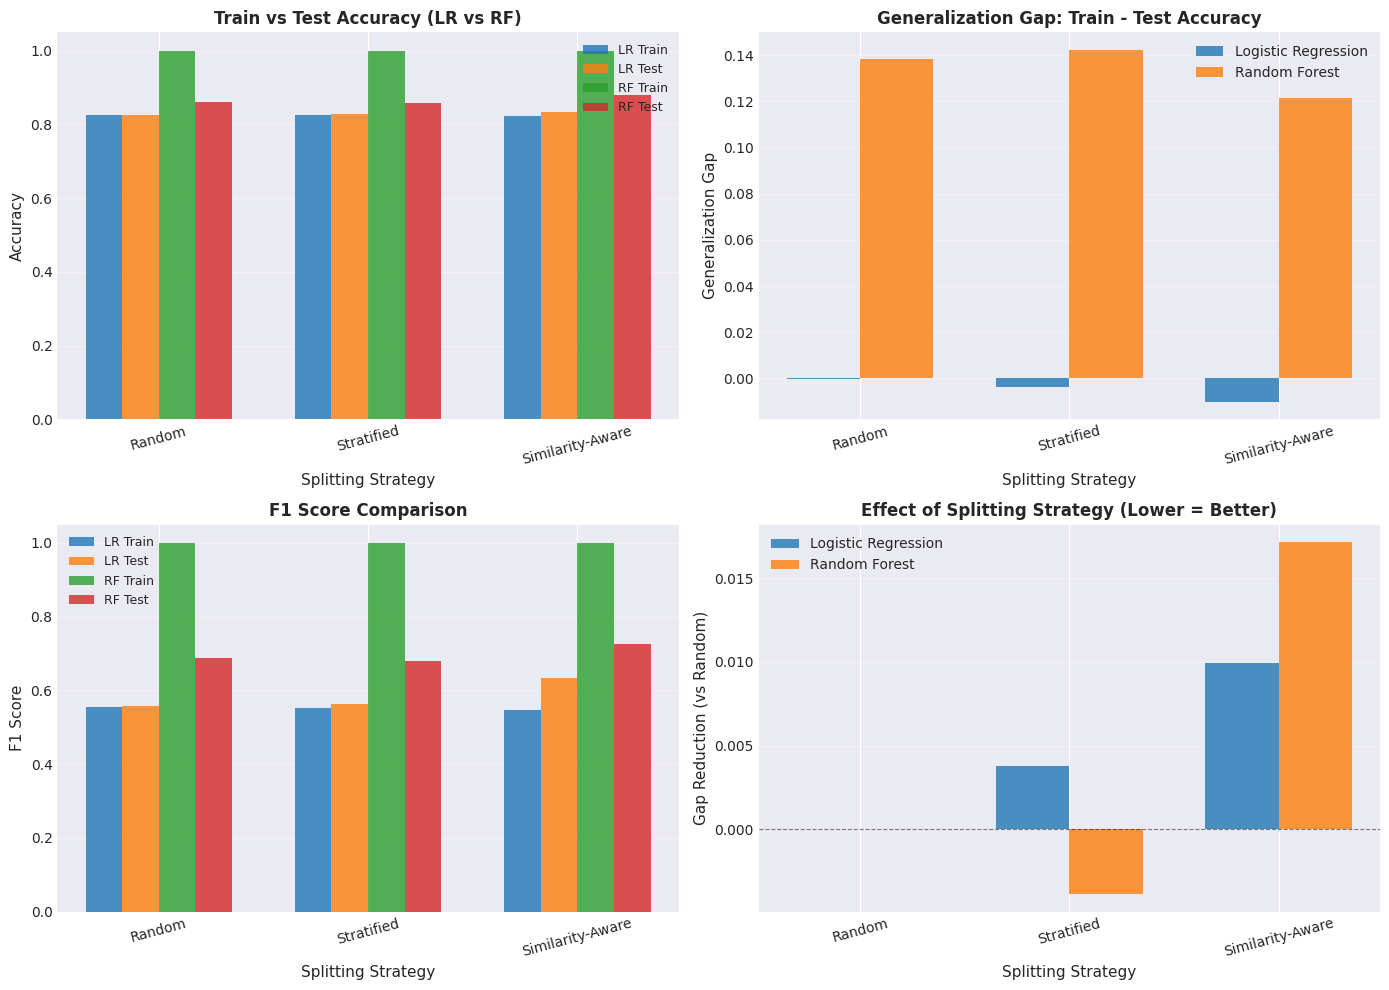

In [6]:
plt.figure(figsize=(15, 10))

splits_list = ['Random', 'Stratified', 'Similarity-Aware']
models_list = list(results.keys())

# Plot 1: Train vs Test Accuracy Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Accuracy comparison across splits for both models
ax1 = axes[0, 0]
x = np.arange(len(splits_list))
width = 0.35

train_accs_lr = [results['Logistic Regression'][split]['train_accuracy'] for split in splits_list]
test_accs_lr = [results['Logistic Regression'][split]['test_accuracy'] for split in splits_list]
train_accs_rf = [results['Random Forest'][split]['train_accuracy'] for split in splits_list]
test_accs_rf = [results['Random Forest'][split]['test_accuracy'] for split in splits_list]

ax1.bar(x - width/2 - width/4, train_accs_lr, width/2, label='LR Train', alpha=0.8)
ax1.bar(x - width/4, test_accs_lr, width/2, label='LR Test', alpha=0.8)
ax1.bar(x + width/4, train_accs_rf, width/2, label='RF Train', alpha=0.8)
ax1.bar(x + width/2 + width/4, test_accs_rf, width/2, label='RF Test', alpha=0.8)
ax1.set_xlabel('Splitting Strategy', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Train vs Test Accuracy (LR vs RF)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(splits_list, rotation=15)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# Subplot 2: Generalization Gap Comparison
ax2 = axes[0, 1]
gaps_lr = [results['Logistic Regression'][split]['gap'] for split in splits_list]
gaps_rf = [results['Random Forest'][split]['gap'] for split in splits_list]

x = np.arange(len(splits_list))
width = 0.35
ax2.bar(x - width/2, gaps_lr, width, label='Logistic Regression', alpha=0.8)
ax2.bar(x + width/2, gaps_rf, width, label='Random Forest', alpha=0.8)
ax2.set_xlabel('Splitting Strategy', fontsize=11)
ax2.set_ylabel('Generalization Gap', fontsize=11)
ax2.set_title('Generalization Gap: Train - Test Accuracy', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(splits_list, rotation=15)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: F1 Score Comparison
ax3 = axes[1, 0]
train_f1_lr = [results['Logistic Regression'][split]['train_f1'] for split in splits_list]
test_f1_lr = [results['Logistic Regression'][split]['test_f1'] for split in splits_list]
train_f1_rf = [results['Random Forest'][split]['train_f1'] for split in splits_list]
test_f1_rf = [results['Random Forest'][split]['test_f1'] for split in splits_list]

x = np.arange(len(splits_list))
ax3.bar(x - width/2 - width/4, train_f1_lr, width/2, label='LR Train', alpha=0.8)
ax3.bar(x - width/4, test_f1_lr, width/2, label='LR Test', alpha=0.8)
ax3.bar(x + width/4, train_f1_rf, width/2, label='RF Train', alpha=0.8)
ax3.bar(x + width/2 + width/4, test_f1_rf, width/2, label='RF Test', alpha=0.8)
ax3.set_xlabel('Splitting Strategy', fontsize=11)
ax3.set_ylabel('F1 Score', fontsize=11)
ax3.set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(splits_list, rotation=15)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Subplot 4: Effect of Splitting Strategy on Gap
ax4 = axes[1, 1]
gap_diff_lr = [gaps_lr[0] - g for g in gaps_lr]  # Effect relative to random split
gap_diff_rf = [gaps_rf[0] - g for g in gaps_rf]

x = np.arange(len(splits_list))
width = 0.35
ax4.bar(x - width/2, gap_diff_lr, width, label='Logistic Regression', alpha=0.8)
ax4.bar(x + width/2, gap_diff_rf, width, label='Random Forest', alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax4.set_xlabel('Splitting Strategy', fontsize=11)
ax4.set_ylabel('Gap Reduction (vs Random)', fontsize=11)
ax4.set_title('Effect of Splitting Strategy (Lower = Better)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(splits_list, rotation=15)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
